# Time series analysis
 Lund University

## Example code 9: Model order estimation.

**Reference:**  
*An Introduction to Time Series Modeling*, 4th ed, by Andreas Jakobsson  
Studentlitteratur, 2021

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter
import sys
import os
import time

# Import tsa library 
sys.path.append(os.path.join('..', 'TimeSeriesAnalysis-main', 'TimeSeriesAnalysis-main'))
from tsa_lth.modelling import estimateARMA

# Configure matplotlib 
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['lines.linewidth'] = 1.0

### Simulate some processes. Ignore the initial samples to avoid any initialization effects.

In [2]:
np.random.seed(0)
extraN = 100
N  = 1000                                      # Try using only N=100 samples.
C  = np.array([ 1, -0.6, 0.5 ])
A  = np.array([ 1, 0.2, 0.3, 0.8 ])
p  = len(A)-1
q  = len(C)-1
e  = np.random.randn( N+extraN )
y1 = lfilter( [1], A, e )[extraN:]
y2 = lfilter( C, A, e )[extraN:]

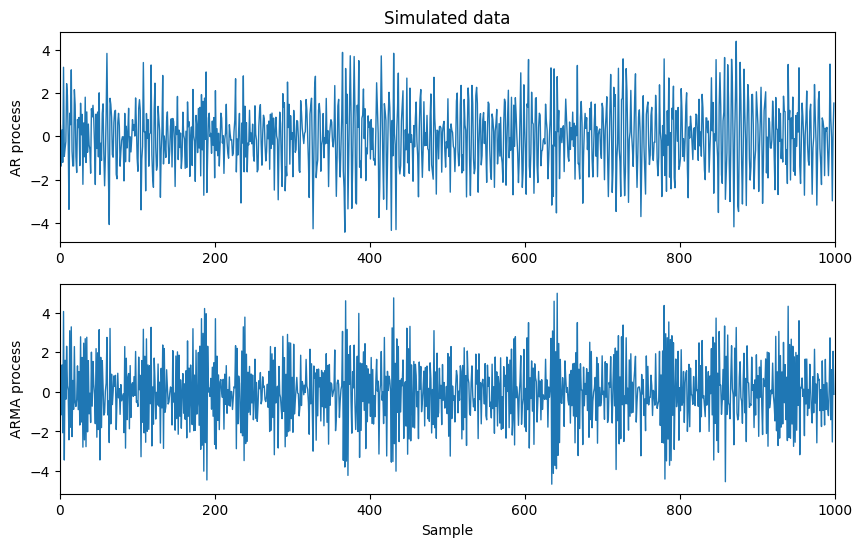

In [3]:
# Examine the data.
plt.figure()
plt.subplot(211)
plt.plot( y1 )
plt.ylabel('AR process')
plt.title('Simulated data')
plt.xlim([0, N])
plt.subplot(212)
plt.plot( y2 )
plt.ylabel('ARMA process')
plt.xlabel('Sample')
plt.xlim([0, N])
plt.show()

## Form the least squares estimate using an AR model of varying order.

In [4]:
pMax = 8
S_th = np.zeros(pMax)
start_time = time.time()
for p_iter in range(1, pMax+1):
    modelAR = estimateARMA(y1, A=p_iter, C=0, plot=False)
    ey = lfilter( modelAR.A, modelAR.C, y1 )[len(modelAR.A)-1:]
    S_th[p_iter-1] = N*np.log( np.var(ey) )

elapsed_time = time.time() - start_time
print(f'Average computational cost per estimate: {1000*elapsed_time/pMax:.2f} ms.')

Average computational cost per estimate: 2.46 ms.


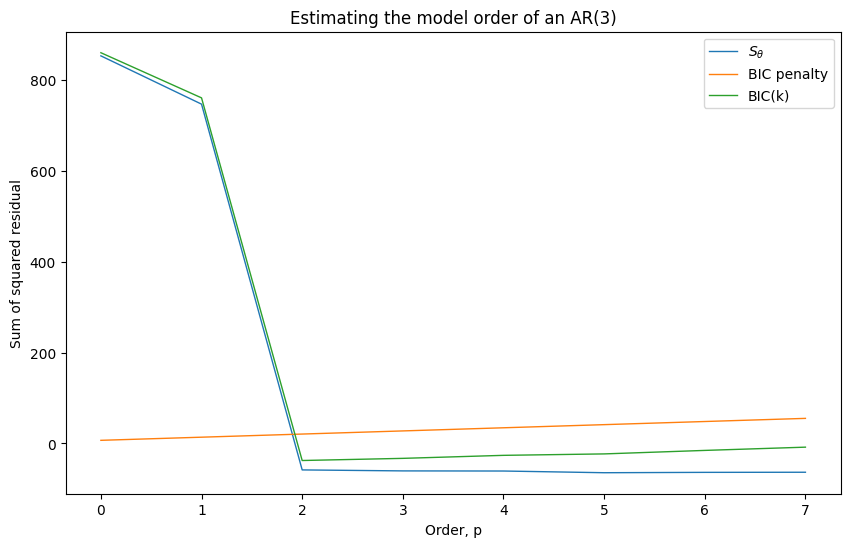

In [5]:
plt.figure()
bic_k = np.arange(1, pMax+1)*np.log(N)
plt.plot( np.column_stack([S_th, bic_k, S_th+bic_k]) )
plt.xlabel('Order, p')
plt.ylabel('Sum of squared residual')
plt.legend(['$S_\\theta$', 'BIC penalty', 'BIC(k)'])
plt.title( f'Estimating the model order of an AR({len(A)-1})' )
plt.show()

## Lets try the same for the ARMA process. 
Note the difference in computational cost!

In [6]:
qMax = 6
S_th = np.zeros((pMax, qMax))
start_time = time.time()
for p_iter in range(1, pMax+1):
    for q_iter in range(1, qMax+1):
        modelARMA = estimateARMA(y2, A=p_iter, C=q_iter, plot=False)
        ey = lfilter( modelARMA.A, modelARMA.C, y2 )[len(modelARMA.A)-1:]
        S_th[p_iter-1, q_iter-1] = N*np.log( np.var(ey) )

elapsed_time = time.time() - start_time
print(f'Average computational cost per estimate: {1000*elapsed_time/pMax/qMax:.2f} ms.')

C:\Users\tadas\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\scipy\optimize\_lsq\trf.py:527: RuntimeWarning: overflow encountered in dot
  cost_new = 0.5 * np.dot(f_new, f_new)


Average computational cost per estimate: 19.45 ms.


C:\Users\tadas\AppData\Local\Temp\ipykernel_5628\916954512.py:6: RuntimeWarning: invalid value encountered in log
  Z = np.log(S_th + bic_pq)


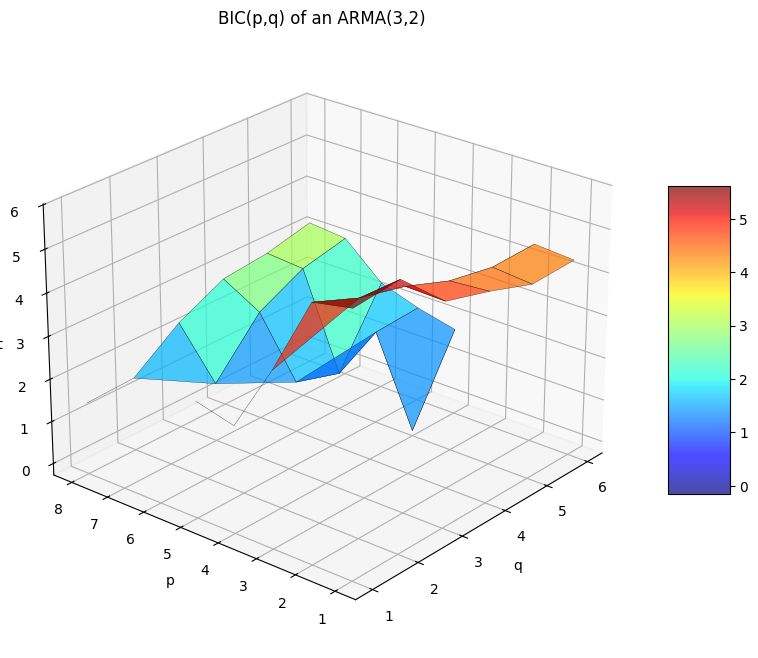

In [7]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
bic_pq = (np.arange(1, pMax+1)[:, np.newaxis] + np.arange(1, qMax+1))*np.log(N)
Q, P = np.meshgrid(np.arange(1, qMax+1), np.arange(1, pMax+1))

Z = np.log(S_th + bic_pq)

surf = ax.plot_surface(Q, P, Z, cmap='jet', 
                       rstride=1, cstride=1, linewidth=0.2, 
                       edgecolor='k', alpha=0.7, antialiased=True)
ax.set_xlabel('q')
ax.set_ylabel('p')
ax.set_zlabel('Cost')
ax.set_title( f'BIC(p,q) of an ARMA({len(A)-1},{len(C)-1})' )
ax.view_init(elev=25, azim=220)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.show()